# 1. Get dataset on screen

In [2]:
# Explore the dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import scale

# Import the provided dataset
data_file = 'banknote_authentication.csv'
df = pd.read_csv(data_file)
df.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [3]:
# Basic summary of the dataset
df.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


In [4]:
# Create a visualization which shows the characteristics of images of class 1, compared to images of class 0
dimensions = ['variance', 'skewness', 'curtosis', 'entropy']

fig = px.scatter_matrix(
    df,
    dimensions=dimensions,
    color='class',
    labels={'class': 'Different<br>classes'},
    title="Characteristics of different classes"
)

fig.show()

# 2. Preprocessing

In [5]:
# Checking for NaN values
df.isnull().sum()

variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

In [6]:
# Normalizing the values of all columns
for column in df.columns:
    min_value = df[column].min()
    max_value = df[column].max()
    df[column] = df[column].apply(lambda x: (x-min_value)/(max_value-min_value))

# 3. Creating a train and test set

In [7]:
from sklearn.model_selection import train_test_split

# Seperate the class label from the dataframe
y = df['class']
X = df.drop(['class'], 1)

# Create the test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# 4. Classification algorithms 

In [8]:
# KNN classifier
from sklearn.neighbors import KNeighborsClassifier

# Define the model
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn.fit(X_train.values, y_train.values)

# Make predictions
knn_predictions = knn.predict(X_test.values)

# Visualize the kNN scatter plot
# Source: https://plotly.com/python/knn-classification/
fig = px.scatter(
    X_test, x='variance', y='skewness',
    color=knn_predictions, color_continuous_scale='RdBu',
    symbol=y_test, symbol_map={'0': 'square-dot', '1': 'circle-dot'},
    labels={'symbol': 'Initial label', 'color': 'Predicted label'},
    title="K-Nearest Neighbor (Training data)"
)

fig.update_traces(marker_size=12, marker_line_width=1.5)
fig.update_layout(legend_orientation='h')
fig.show()

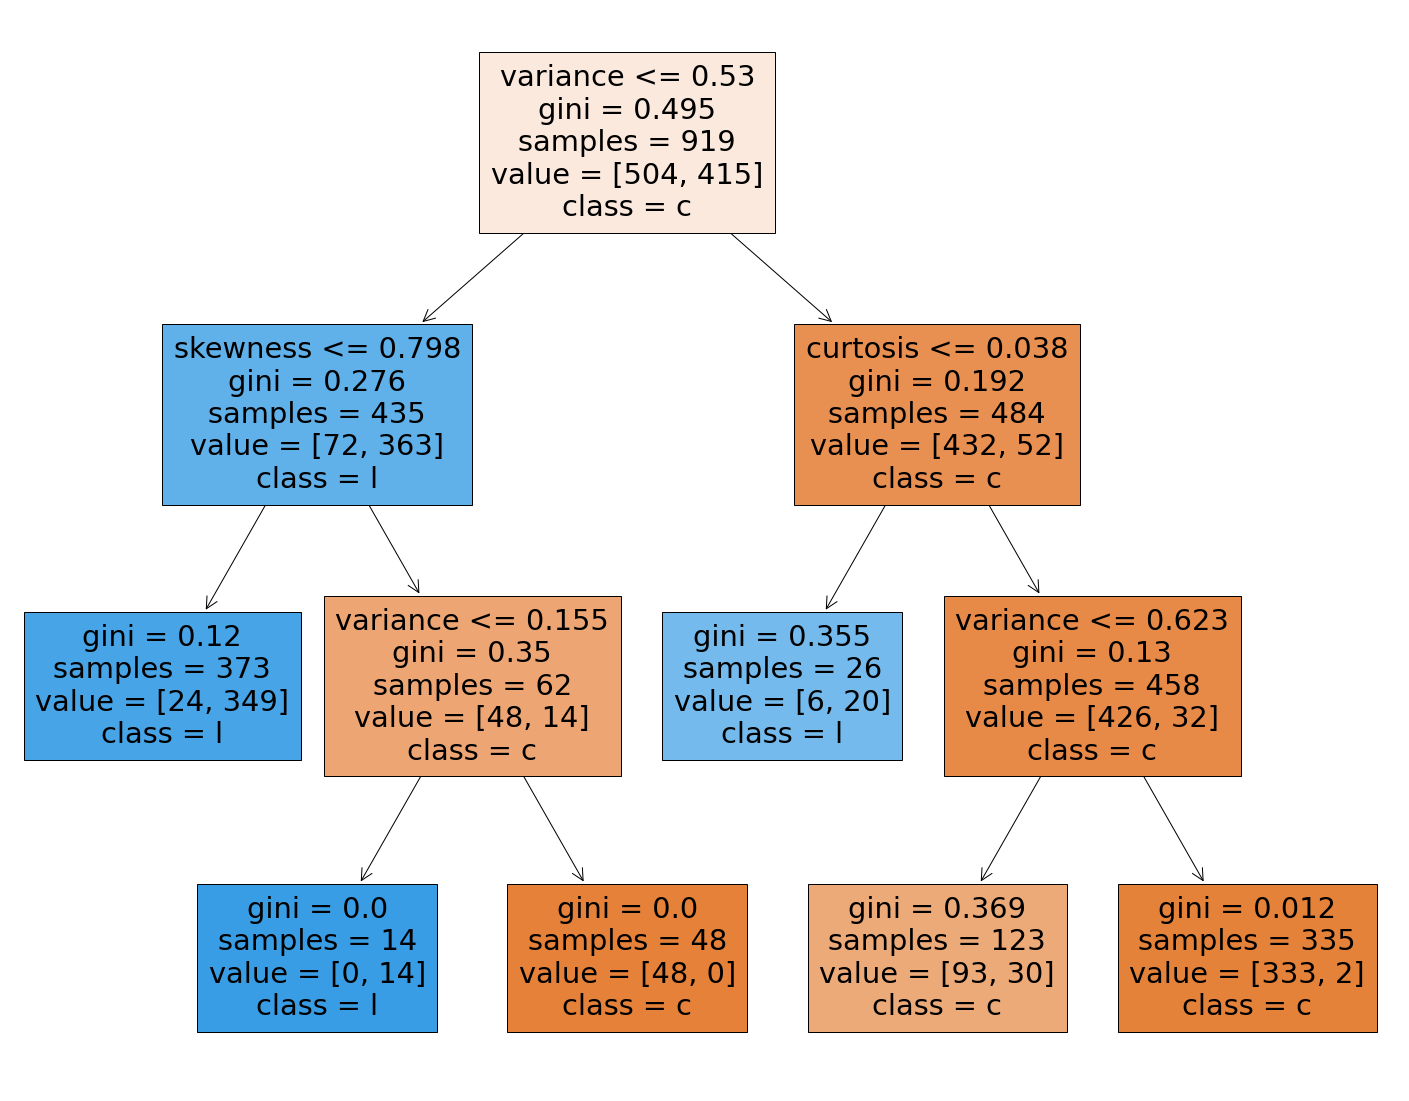

In [9]:
# Decision tree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Define the model
dtree = DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    max_leaf_nodes=6
)

# Train the model
dtree.fit(X_train, y_train)

# Make predictions
dtree_predictions = dtree.predict(X_test)

# Visualize the tree
fig_size = plt.figure(figsize=(25,20))
figure = tree.plot_tree(
    dtree,
    filled=True,
    class_names='class',
    feature_names=dimensions
)

In [10]:
# Suport vector machine
from sklearn.svm import SVC

# Define the model
svc = SVC(
    kernel='rbf',
    gamma='scale'
)

# Train the model
svc.fit(X_train, y_train)

# Make predictions
svc_predictions = svc.predict(X_test)

In [11]:
 # Voting classifier
from sklearn.ensemble import VotingClassifier

# Define the parameters for the model
classifier_1 = KNeighborsClassifier(n_neighbors=7)
classifier_2 = DecisionTreeClassifier(max_depth=4)
classifier_3 = SVC(gamma='scale', kernel='rbf', probability=True)

# Define the model
vc_models = [
    ('knn', classifier_1),
    ('dtree', classifier_2),
    ('svc', classifier_3)
]

voting_classifier = VotingClassifier(
    estimators=vc_models,
    voting='soft',
    weights=[2, 1, 2]
)

# Train the model
classifier_1.fit(X_train, y_train)
classifier_2.fit(X_train, y_train)
classifier_3.fit(X_train, y_train)
voting_classifier.fit(X_train, y_train)

# Make predictions
vc_predictions = voting_classifier.predict(X_test)

# 5. Evaluation of classification methods

In [12]:
# Confusion matrix
import plotly.figure_factory as ff
import plotly.graph_objects as go

# Defining all the model predictions
model_predictions = {
    "K-nearest neighbors": knn_predictions,
    'Decision tree': dtree_predictions,
    'Support vector machine': svc_predictions,
    'Voting classifier': vc_predictions
}

# Looping through the predictions and building a confusion matrix
for name, predicted in model_predictions.items():
    # Splitting the good and false predictions
    good_prediction = [i for i, j in zip(predicted, y_test) if i == j]
    false_prediction = [i for i, j in zip(predicted, y_test) if i != j]

    # Defining the matrix data
    true_positives = good_prediction.count(1)
    true_negatives = good_prediction.count(0)
    false_positives = false_prediction.count(1)
    false_negatives = false_prediction.count(0)

    # Making the confusion matrix
    confusion_data = [[true_positives, false_positives], [false_negatives, true_negatives]]
    confusion_matrix = pd.DataFrame(confusion_data)
    
    x_axis = ['Positive', 'Negative']
    y_axis = ['Positive', 'Negative']
    z_text = [['asd', 'asd'], ['asd', 'ad']]
    
    # Plotting the confusion matrix
    fig = ff.create_annotated_heatmap(
        confusion_data,
        x=x_axis,
        y=y_axis,
        colorscale='inferno',
        annotation_text=confusion_data,        
        )
    
    # Update the title
    fig.layout.update(go.Layout(title=go.layout.Title(text=name)))
    
    fig.show()

In [13]:
# Classification report
from sklearn.metrics import classification_report

# KNN classification
print(classification_report(y_test, knn_predictions))

# Decision tree classification
print(classification_report(y_test, dtree_predictions))

# Suport vector classification
print(classification_report(y_test, svc_predictions))

# Suport vector classification
print(classification_report(y_test, vc_predictions))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       258
         1.0       0.99      1.00      1.00       195

    accuracy                           1.00       453
   macro avg       1.00      1.00      1.00       453
weighted avg       1.00      1.00      1.00       453

              precision    recall  f1-score   support

         0.0       0.94      0.93      0.93       258
         1.0       0.90      0.92      0.91       195

    accuracy                           0.92       453
   macro avg       0.92      0.92      0.92       453
weighted avg       0.93      0.92      0.93       453

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       258
         1.0       1.00      1.00      1.00       195

    accuracy                           1.00       453
   macro avg       1.00      1.00      1.00       453
weighted avg       1.00      1.00      1.00       453

              preci

In [14]:
# Fbeta score
from sklearn.metrics import fbeta_score

# Calculate the scores
knn_fbeta = fbeta_score(y_test, knn_predictions, beta=0.5)
dtree_fbeta = fbeta_score(y_test, dtree_predictions, beta=0.5)
svc_fbeta = fbeta_score(y_test, svc_predictions, beta=0.5)
vc_fbeta = fbeta_score(y_test, vc_predictions, beta=0.5)

# Make a dataframe with the scores
fbeta_scores = {
    'KNN': knn_fbeta,
    'DTree': dtree_fbeta,
    'SVC': svc_fbeta,
    'VC': vc_fbeta
}

# Print the results
for name, result in fbeta_scores.items():
    print(name, ' has a fbeta score of: ', result)

KNN  has a fbeta score of:  0.9959141981613893
DTree  has a fbeta score of:  0.9081735620585268
SVC  has a fbeta score of:  1.0
VC  has a fbeta score of:  1.0


# 6. Cross-validation

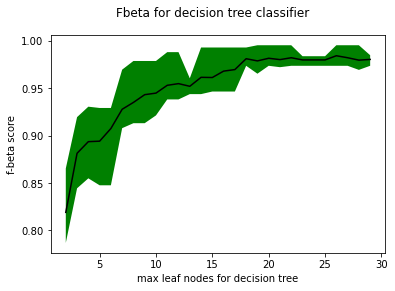

In [26]:
# K-Fold cross-validation
from sklearn.model_selection import KFold

# Iterate over different parameters
scores_mean = []
scores_low = []
scores_high = []
scores_n = []
for k in [k for k in range (2, 30)]:
    # Create classifier for current parameter
    dtree_opt = DecisionTreeClassifier(
        criterion='gini',
        splitter='best',
        max_leaf_nodes=k
    )
    
    # K-Fold the training data
    kf = KFold(n_splits=5)

    # Start iterating over the folds
    train_scores = []
    for train_index, validate_index in kf.split(X_train):
        # Build data folds
        kf_X_train, kf_X_validate = X_train.iloc[train_index], X_train.iloc[validate_index]
        kf_y_train, kf_y_validate = y_train.iloc[train_index], y_train.iloc[validate_index]
        
        # Train the model
        dtree_opt.fit(kf_X_train, kf_y_train)

        # Make predictions
        dtree_opt_predictions = dtree_opt.predict(kf_X_validate)

        # Calculate prediction result
        train_scores.append(fbeta_score(kf_y_validate, dtree_opt_predictions, beta=0.5))
    
    scores_mean.append(np.mean(train_scores))
    scores_low.append(np.min(train_scores))
    scores_high.append(np.max(train_scores))
    scores_n.append(k)

plt.plot(scores_n, scores_mean, color='black')
plt.fill_between(scores_n, scores_low, scores_high, facecolor='green', interpolate=True)
plt.suptitle("F-beta for decision tree classifier")
plt.xlabel('max leaf nodes for decision tree')
plt.ylabel('f-beta score')
plt.show()